In [1]:
# Peter Karras 2020
'''Takes GPP and date information from old master file and creates a new Machine Learning Master File
   With one column representing file names for the converted CSVs and the other column being their respective
   GPPs as pulled from the old master file or calculated with linear interpolation'''

'Takes GPP and date information from old master file and creates a new Machine Learning Master File\n   With one column representing file names for the converted CSVs and the other column being their respective\n   GPPs as pulled from the old master file or calculated with linear interpolation'

In [2]:
import pandas as pd
import os
import time

In [3]:
# Takes in a string that represents name of csv file and 
# converts that string to one that matches the date string present
# in the old master file (old master file refers to the raw excel file
# filled with extraneous data from BCI)that contains the date/times 
# for recorded GPP values
def change_csv_date(csv):
    year = csv[2:4]
    month = csv[5:7]
    day = csv[8:10]
    hour = csv[11:13]
    minute = csv[14:16]
    second = "00"
    if(int(hour) == 0):
        hour = "0"
    elif(int(hour) < 10):
        hour = hour[1:2]
    # No leading zeroes in day or month
    if(int(month) < 10):
        month = month[1:2]
    if(int(day) < 10):
        day = day[1:2]
    result = month + "/" + day + "/" + year + " " + hour + ":" + minute #+ ":" + second + " " + timeDay
    return result

In [4]:
# Takes in csv date (in format 'YYYY_MM_DD_HH_MM_bci_t') and checks to see if minutes are divisble by div
def check_csv_date(csv, div):
    result = False
    minute = int(csv[14:16])
    remainder = minute % div
    if(remainder == 0):
        result = True
    else:
        result = False
    return result

In [5]:
print(check_csv_date("2015_03_14_14_00_bci_t.csv",30))

True


In [7]:
# Grabs all GPP values and dates from master file (as defined above)
masterfileLocation = r"C:\Users\Peter\Desktop\Thermo_R_Code\FinalThermo\new2"
os.chdir(masterfileLocation)
col_list = ["date", "GPP"]
masterFileName = "all-30min-Apr2018_working.csv"
dateGPPList = pd.read_csv(masterFileName, usecols=col_list) 
dateGPPList = dateGPPList.set_index("date")



csvdataLocation = r"C:\Users\Peter\Desktop\Thermo_R_Code\FinalThermo\new2\csvdataFULL\BCIML_Dataset"
(_, _, csvfiles) = next(os.walk(csvdataLocation))
print(csvfiles[0])

2015_03_14_13_30_bci_t.csv


In [8]:
# This chunk of code matches the file names from the old master file to the
# names gotten from the "csvdata" folder, so that each thermal csv file has it's
# corresponding GPP value matched to it
# NOTE: In addition to matching GPP values, this code also fills in GPP values
# for those images without recorded values through linear interpoaltion
# NOTE: Currently only works when first CSV is from a 30 min increment
# NOTE: Anomolies in data make it so sometimes data moves in 1 minute increments, 
# currently this function cannot circumvents this and these files must be removed

# NOTE: Still has issues when there is a gap within masterfile data, currently just files
# intermeditate values with last known val for GPP

dictList = list()

counter = 0
numLoops = len(csvfiles)
oldGPP = -1.1
for i in range(0, numLoops, 6):
    #GPPDataDict.clear()
    currFile = csvfiles[i]
    adaptedDate = change_csv_date(currFile)
    try:
        currGPP = dateGPPList.at[adaptedDate,"GPP"]
    except:
        print("Gap in time: ", adaptedDate)
    if(i == 0):
        #GPPDataDict.update({currFile : currGPP})
        GPPDataDict = dict()
        GPPDataDict.update({"GPP" : currGPP})
        GPPDataDict.update({"FILE" : currFile})
        dictList.append(GPPDataDict)
        oldGPP = currGPP
        continue
        
    GPPDataDictTemp = dict()
    GPPDataDictTemp.update({"GPP" : currGPP})
    GPPDataDictTemp.update({"FILE" : currFile})
    
    
    diffGPP = currGPP - oldGPP
    increment = diffGPP / 6.0
    for j in range(i-5, i, 1):
        oldGPP += increment
        currFile = csvfiles[j]
        #print("Here", currFile)
        GPPDataDict = dict()
        GPPDataDict.update({"GPP" : oldGPP})
        GPPDataDict.update({"FILE" : currFile})
        dictList.append(GPPDataDict)
    dictList.append(GPPDataDictTemp)
    oldGPP = currGPP + increment
    oldGPP = currGPP

Gap in time:  4/2/15 11:47
Gap in time:  4/2/15 11:53
Gap in time:  4/2/15 11:59
Gap in time:  4/2/15 12:05
Gap in time:  4/2/15 12:11
Gap in time:  4/2/15 12:17
Gap in time:  4/2/15 12:23
Gap in time:  4/2/15 12:29
Gap in time:  4/2/15 12:35
Gap in time:  4/2/15 12:41
Gap in time:  4/2/15 12:47
Gap in time:  4/2/15 12:53
Gap in time:  4/2/15 12:59
Gap in time:  4/2/15 13:05
Gap in time:  4/2/15 13:11
Gap in time:  4/2/15 13:17
Gap in time:  4/2/15 13:23
Gap in time:  4/2/15 13:29
Gap in time:  4/2/15 13:35
Gap in time:  4/2/15 13:41
Gap in time:  4/2/15 13:47
Gap in time:  4/2/15 15:50
Gap in time:  4/2/15 15:56
Gap in time:  4/2/15 16:02
Gap in time:  4/2/15 16:08
Gap in time:  4/2/15 16:14
Gap in time:  4/2/15 16:20
Gap in time:  4/2/15 16:26
Gap in time:  4/2/15 16:32
Gap in time:  4/2/15 16:40
Gap in time:  4/2/15 17:10
Gap in time:  4/2/15 17:40
Gap in time:  4/2/15 18:10
Gap in time:  4/2/15 18:40
Gap in time:  4/2/15 19:10
Gap in time:  4/2/15 19:40
Gap in time:  4/2/15 20:10
G

Gap in time:  4/27/15 12:10
Gap in time:  4/27/15 12:40
Gap in time:  4/27/15 13:10
Gap in time:  4/27/15 13:40
Gap in time:  4/27/15 14:10
Gap in time:  4/27/15 14:40
Gap in time:  4/27/15 15:10
Gap in time:  4/27/15 15:40
Gap in time:  4/27/15 16:10
Gap in time:  4/27/15 16:40
Gap in time:  4/27/15 17:10
Gap in time:  4/27/15 17:40
Gap in time:  4/27/15 18:10
Gap in time:  4/27/15 18:40
Gap in time:  4/27/15 19:10
Gap in time:  4/27/15 19:40
Gap in time:  4/27/15 20:10
Gap in time:  4/27/15 20:40
Gap in time:  4/27/15 21:10
Gap in time:  4/27/15 21:40
Gap in time:  4/27/15 22:10
Gap in time:  4/27/15 22:40
Gap in time:  4/27/15 23:10
Gap in time:  4/27/15 23:40
Gap in time:  4/28/15 0:10
Gap in time:  4/28/15 0:40
Gap in time:  4/28/15 1:10
Gap in time:  4/28/15 1:40
Gap in time:  4/28/15 2:10
Gap in time:  4/28/15 2:40
Gap in time:  4/28/15 3:10
Gap in time:  4/28/15 3:40
Gap in time:  4/28/15 4:10
Gap in time:  4/28/15 4:40
Gap in time:  4/28/15 5:10
Gap in time:  4/28/15 5:40
Gap 

Gap in time:  5/22/15 16:40
Gap in time:  5/22/15 17:10
Gap in time:  5/22/15 17:40
Gap in time:  5/22/15 18:10
Gap in time:  5/22/15 18:40
Gap in time:  5/22/15 19:10
Gap in time:  5/22/15 19:40
Gap in time:  5/22/15 20:10
Gap in time:  5/22/15 20:40
Gap in time:  5/22/15 21:10
Gap in time:  5/22/15 21:40
Gap in time:  5/22/15 22:10
Gap in time:  5/22/15 22:40
Gap in time:  5/22/15 23:10
Gap in time:  5/22/15 23:40
Gap in time:  5/23/15 0:10
Gap in time:  5/23/15 0:40
Gap in time:  5/23/15 1:10
Gap in time:  5/23/15 1:40
Gap in time:  5/23/15 2:10
Gap in time:  5/23/15 2:40
Gap in time:  5/23/15 3:10
Gap in time:  5/23/15 3:40
Gap in time:  5/23/15 4:10
Gap in time:  5/23/15 4:40
Gap in time:  5/23/15 5:10
Gap in time:  5/23/15 5:40
Gap in time:  5/23/15 6:10
Gap in time:  5/23/15 6:40
Gap in time:  5/23/15 7:10
Gap in time:  5/23/15 7:40
Gap in time:  5/23/15 8:10
Gap in time:  5/23/15 8:40
Gap in time:  5/23/15 9:10
Gap in time:  5/23/15 9:40
Gap in time:  5/23/15 10:10
Gap in time:

Gap in time:  6/15/15 6:40
Gap in time:  6/15/15 7:10
Gap in time:  6/15/15 7:40
Gap in time:  6/15/15 8:10
Gap in time:  6/15/15 8:40
Gap in time:  6/15/15 9:10
Gap in time:  6/15/15 9:40
Gap in time:  6/15/15 10:10
Gap in time:  6/15/15 10:40
Gap in time:  6/15/15 11:10
Gap in time:  6/15/15 11:40
Gap in time:  6/15/15 12:10
Gap in time:  6/15/15 12:40
Gap in time:  6/15/15 13:10
Gap in time:  6/15/15 13:40
Gap in time:  6/15/15 14:10
Gap in time:  6/15/15 14:40
Gap in time:  6/15/15 15:10
Gap in time:  6/15/15 15:40
Gap in time:  6/15/15 16:10
Gap in time:  6/15/15 16:40
Gap in time:  6/15/15 17:10
Gap in time:  6/15/15 17:40
Gap in time:  6/15/15 18:10
Gap in time:  6/15/15 18:40
Gap in time:  6/15/15 19:10
Gap in time:  6/15/15 19:40
Gap in time:  6/15/15 20:10
Gap in time:  6/15/15 20:40
Gap in time:  6/15/15 21:10
Gap in time:  6/15/15 21:40
Gap in time:  6/15/15 22:10
Gap in time:  6/15/15 22:40
Gap in time:  6/15/15 23:10
Gap in time:  6/15/15 23:40
Gap in time:  6/16/15 0:10


Gap in time:  7/9/15 9:40
Gap in time:  7/9/15 10:10
Gap in time:  7/9/15 10:40
Gap in time:  7/9/15 11:10
Gap in time:  7/9/15 11:40
Gap in time:  7/9/15 12:10
Gap in time:  7/9/15 12:40
Gap in time:  7/9/15 13:10
Gap in time:  7/9/15 13:40
Gap in time:  7/9/15 14:10
Gap in time:  7/9/15 14:40
Gap in time:  7/9/15 15:10
Gap in time:  7/9/15 15:40
Gap in time:  7/9/15 16:10
Gap in time:  7/9/15 16:40
Gap in time:  7/9/15 17:10
Gap in time:  7/9/15 17:40
Gap in time:  7/9/15 18:10
Gap in time:  7/9/15 18:40
Gap in time:  7/9/15 19:10
Gap in time:  7/9/15 19:40
Gap in time:  7/9/15 20:10
Gap in time:  7/9/15 20:40
Gap in time:  7/9/15 21:10
Gap in time:  7/9/15 21:40
Gap in time:  7/9/15 22:10
Gap in time:  7/9/15 22:40
Gap in time:  7/9/15 23:10
Gap in time:  7/9/15 23:40
Gap in time:  7/10/15 0:10
Gap in time:  7/10/15 0:40
Gap in time:  7/10/15 1:10
Gap in time:  7/10/15 1:40
Gap in time:  7/10/15 2:10
Gap in time:  7/10/15 2:40
Gap in time:  7/10/15 3:10
Gap in time:  7/10/15 3:40
Ga

Gap in time:  8/7/15 12:55
Gap in time:  8/7/15 13:25
Gap in time:  8/7/15 13:55
Gap in time:  8/7/15 14:25
Gap in time:  8/7/15 14:55
Gap in time:  8/7/15 15:25
Gap in time:  8/7/15 15:55
Gap in time:  8/7/15 16:25
Gap in time:  8/7/15 16:55
Gap in time:  8/7/15 17:25
Gap in time:  8/7/15 17:55
Gap in time:  8/7/15 18:25
Gap in time:  8/7/15 18:55
Gap in time:  8/7/15 19:25
Gap in time:  8/7/15 19:55
Gap in time:  8/7/15 20:25
Gap in time:  8/7/15 20:55
Gap in time:  8/7/15 21:25
Gap in time:  8/7/15 21:55
Gap in time:  8/7/15 22:25
Gap in time:  8/7/15 22:55
Gap in time:  8/7/15 23:25
Gap in time:  8/7/15 23:55
Gap in time:  8/8/15 0:25
Gap in time:  8/8/15 0:55
Gap in time:  8/8/15 1:25
Gap in time:  8/8/15 1:55
Gap in time:  8/8/15 2:25
Gap in time:  8/8/15 2:55
Gap in time:  8/8/15 3:25
Gap in time:  8/8/15 3:55
Gap in time:  8/8/15 4:25
Gap in time:  8/8/15 4:55
Gap in time:  8/8/15 5:25
Gap in time:  8/8/15 5:55
Gap in time:  8/8/15 6:25
Gap in time:  8/8/15 6:55
Gap in time:  8

Gap in time:  9/6/15 5:15
Gap in time:  9/6/15 5:45
Gap in time:  9/6/15 6:15
Gap in time:  9/6/15 6:45
Gap in time:  9/6/15 7:15
Gap in time:  9/6/15 7:45
Gap in time:  9/6/15 8:15
Gap in time:  9/6/15 8:45
Gap in time:  9/6/15 9:15
Gap in time:  9/6/15 9:45
Gap in time:  9/6/15 10:15
Gap in time:  9/6/15 10:45
Gap in time:  9/6/15 11:15
Gap in time:  9/6/15 11:45
Gap in time:  9/6/15 12:15
Gap in time:  9/6/15 12:45
Gap in time:  9/6/15 13:15
Gap in time:  9/6/15 13:45
Gap in time:  9/6/15 14:15
Gap in time:  9/6/15 14:45
Gap in time:  9/6/15 15:15
Gap in time:  9/6/15 15:45
Gap in time:  9/6/15 16:15
Gap in time:  9/6/15 16:45
Gap in time:  9/6/15 17:15
Gap in time:  9/6/15 17:45
Gap in time:  9/6/15 18:15
Gap in time:  9/6/15 18:45
Gap in time:  9/6/15 19:15
Gap in time:  9/6/15 19:45
Gap in time:  9/6/15 20:15
Gap in time:  9/6/15 20:45
Gap in time:  9/6/15 21:15
Gap in time:  9/6/15 21:45
Gap in time:  9/6/15 22:15
Gap in time:  9/6/15 22:45
Gap in time:  9/6/15 23:15
Gap in time

In [9]:
# This writes a NEW master file, with one column containing the
# thermal csv file names, and the other column containing their
# GPP values as determined from previous code. New file name is 
# determined by variable csv_file1

import csv
saveLocation = csvdataLocation
os.chdir(saveLocation)
csv_file1 = "populatedGPPs.csv"
csv_columns = ['FILE','GPP']
try:
    with open(csv_file1, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n', fieldnames=csv_columns)
        writer.writeheader()
        for data in dictList:
            writer.writerow(data)
except IOError:
    print("I/O error")
    


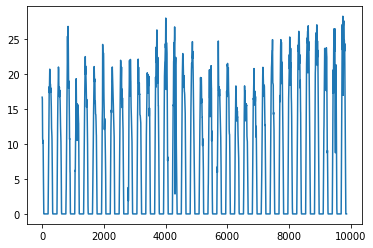

<Figure size 1440x360 with 0 Axes>

In [35]:
import numpy as np
import matplotlib.pyplot as plt

#csv_master_path = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdataFULL/BCIML_Dataset/populatedGPPs.csv"
csv_master_path = r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2/csvdata10000/populatedGPPs.csv"
data_info = pd.read_csv(csv_master_path)
GPP_arr = np.asarray(data_info.iloc[:,1])
fig=plt.figure()
plt.plot(GPP_arr)
plt.figure(figsize=(20,5))
os.chdir(r"C:/Users/Peter/Desktop/Thermo_R_Code/FinalThermo/new2")
fig.savefig('gpp_file.png')
plt.show()